# Bengali.AI Competition - Model Training (Convolutional)

### Team MuchLearningSuchWow

This notebook contains the code that we used to train the convolutional network with cyclical learning rate but without class weights. The core of this code (network, training procedure, etc.) is based on [this kernel](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn). This notebook uses the preprocessed data as produced by our preprocessing notebook. Note that this code is not intended to run on kaggle; to run this code on kaggle, add "/kaggle/" in front of all filenames.

## Imports

In [0]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2
import os
import pickle

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization,Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

Using TensorFlow backend.


## Constants

In [0]:
IMG_SIZE=64
N_CHANNELS=1

## Filenames

In [0]:
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [0]:
train_df_filename = "input/bengaliai-cv19/train.csv"
train_filename = "output/train_image_data_preprocessed.parquet"
model_filename = "output/best_model_conv_NoCW.hdf5"

In [ ]:
if not os.path.isdir('output'):
    os.mkdir('output')

## Load Dataframes

In [0]:
train_df = pd.read_csv(train_df_filename)

In [0]:
print(f'Size of training data: {train_df.shape}')

Size of training data: (200840, 5)


In [0]:
train_df = train_df.drop(['grapheme'], axis=1, inplace=False)
train_df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [0]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

## Building Convolutional Model

In [0]:
def build_convolutional():
    inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
    model = Dropout(rate=0.3)(model)

    model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = Dropout(rate=0.3)(model)

    model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = Dropout(rate=0.3)(model)

    model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = Dropout(rate=0.3)(model)

    model = Flatten()(model)
    model = Dense(1024, activation = "relu")(model)
    model = Dropout(rate=0.3)(model)
    dense = Dense(512, activation = "relu")(model)

    head_root = Dense(168, activation = 'softmax', name='dense_root')(dense)
    head_vowel = Dense(11, activation = 'softmax', name='dense_vowel')(dense)
    head_consonant = Dense(7, activation = 'softmax', name='dense_consonant')(dense)

    model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[0.5, 0.25, 0.25])
    model.summary()
    
    return model

In [0]:
model = build_convolutional()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   9248     

## Cyclical Learning Rate

In [0]:
# Source: https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/callbacks/cyclical_learning_rate.py

class CyclicLR(Callback):

    def __init__( self, base_lr=0.001, max_lr=0.006, step_size=2000.,
                  mode='triangular', gamma=1., scale_fn=None, scale_mode='cycle'):
        
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2', 'exp_range']:
            raise KeyError("mode must be one of 'triangular', 'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

## Training

In [0]:
batch_size = 256
epochs = 50

In [0]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self, x, y=None, batch_size=32, shuffle=True, sample_weight=None,  
             seed=None, save_to_dir=None, save_prefix='', save_format='png', subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size, shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [0]:
train_df_full = pd.merge(pd.read_parquet(train_filename), train_df, on='image_id').drop(['image_id'], axis=1)

X_train = train_df_full.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    
# CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
Y_train_root = pd.get_dummies(train_df_full['grapheme_root']).values
Y_train_vowel = pd.get_dummies(train_df_full['vowel_diacritic']).values
Y_train_consonant = pd.get_dummies(train_df_full['consonant_diacritic']).values

print(f'Training images: {X_train.shape}')
print(f'Training labels root: {Y_train_root.shape}')
print(f'Training labels vowel: {Y_train_vowel.shape}')
print(f'Training labels consonants: {Y_train_consonant.shape}')

# Divide the data into training and validation set
x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
del train_df_full
del X_train
del Y_train_root, Y_train_vowel, Y_train_consonant

# Data augmentation for creating more training data
datagen = MultiOutputDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# This will just calculate parameters required to augment the given data. This won't perform any augmentations
datagen.fit(x_train)
    
# Cyclic Learning Rate
clr = CyclicLR(mode='triangular2',
               base_lr=0.00001,
               max_lr=0.001,
               step_size=4 * (x_train.shape[0] // batch_size))
    
# Add saving only the best model
mcp_save = ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss', mode='min')

# Fit the model
history = model.fit_generator(datagen.flow(x_train, 
                                           {'dense_root': y_train_root, 'dense_vowel': y_train_vowel, 'dense_consonant': y_train_consonant}, 
                                           batch_size=batch_size), 
                              epochs=epochs, 
                              validation_data=(x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[clr, mcp_save])

# Delete to reduce memory usage
del x_train
del x_test
del y_train_root
del y_test_root
del y_train_vowel
del y_test_vowel
del y_train_consonant
del y_test_consonant
gc.collect()

Training images: (200840, 64, 64, 1)
Training labels root: (200840, 168)
Training labels vowel: (200840, 11)
Training labels consonants: (200840, 7)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
721/721 [==============================] - 125s 174ms/step - loss: 3.0171 - dense_root_loss: 4.6283 - dense_vowel_loss: 1.7207 - dense_consonant_loss: 1.0911 - dense_root_acc: 0.0414 - dense_vowel_acc: 0.3814 - dense_consonant_acc: 0.6434 - val_loss: 2.5659 - val_dense_root_loss: 4.2117 - val_dense_vowel_loss: 1.0539 - val_dense_consonant_loss: 0.7863 - val_dense_root_acc: 0.0843 - val_dense_vowel_acc: 0.6365 - val_dense_consonant_acc: 0.7216
Epoch 2/50
721/721 [==============================] - 116s 161ms/step - loss: 1.7522 - dense_root_loss: 2.8581 - dense_vowel_loss: 0.7139 - dense_consonant_loss: 0.5788 - dense_root_acc: 0.2658 - dense_vowel_acc: 0.7491 - dense_consonant_acc: 0.7939 - val_loss: 0.8836 - val_dense_root_loss: 1.446

62

## Plotting Losses and Accuracies

In [0]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_root_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_vowel_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_consonant_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_root_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_vowel_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_consonant_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['dense_root_acc'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_vowel_acc'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_consonant_acc'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_root_acc'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_vowel_acc'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_consonant_acc'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

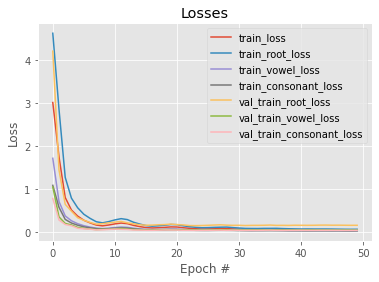

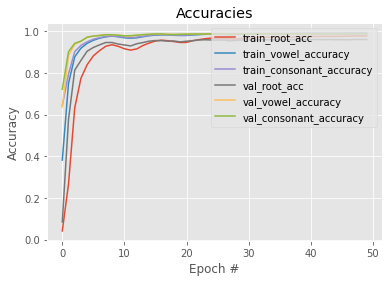

In [0]:
plot_loss(history, epochs, 'Losses')
plot_acc(history, epochs, 'Accuracies')

In [0]:
with open("output/hist_nocw.pkl", "wb") as f:
  pickle.dump(history, f)